# Main ideas

This notebook brings some predictions related to INPE's data about the blazing events in Brazil,
[here](http://queimadas.dgi.inpe.br/queimadas/bdqueimadas). 

At first, I have two main plans for this notebook:

Firstly, I plan to make a time series forecasting concerning the burning events.

### A brief digression about the possible solutions

By what we have already investigated, we observe that for most biomes we have during
the first months of the year a high precipitation rate, where the humidity is pretty high
(Season I). After these beginning months, it enters the dry season, where the preciptation
is majoritly very low and, consequently, the humidity as well. During the last month
of this season, it is starts the *burning season*, where the blazing events start occurring
in a big scale (Season II). Then, within the last two-theee months of the year the precipitation
starts increasing again, the burning events starts decreasing. This *pattern* happens every
year for most of the biomes. Therefore we observe a seasonal pattern across the years and
we are motivated to use a forecasting model (or a ML algorithm) which encompass this feature
of our data.

For the forecasting model there are several options. We could remove the
seasonality of our data and make use of [ARIMA models](https://otexts.com/fpp2/arima.html)
(for a brief introduction check [wikipedia](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)). However, since we already know beforehand
that we have this seasonality involved, we can make use of the Seasonal ARIMA model (SARIMA).
There are also possibilities like the [Holt-Winters seasonal method](https://otexts.com/fpp2/holt-winters.html).
To what concerns the latter it makes an exponential smoothing of the past weights, *i.e.,*
the weights decay exponentially as the observations get older.


We could make use of some shift techniques (based on the seasonality of our data) to
make it suitable for a ML application, where the original data corresponds to the *features*
and the shift data corresponds to the *targets*. For the ML algorithm we could use a
[random forest model for forecasting](https://machinelearningmastery.com/random-forest-for-time-series-forecasting/), for example.

The second part of this work is to take the forecasting and turn it into a more appealing plot
(similar to what have we have done).

A possible extension of this work (for sake of curiosity) would be to compare
the ML models and the classical statistical prediction.


# Data treatment strategy

Since we are going to basically take several dataframes and stack on top of each other
for several years, we can speed up the process if we choose it wisely. For doing so,
we only consider the *risco-fogo* column and where it indeed occurred, *df['risco-fogo']==1*.
However, since we are going to analyse it for several years, we can *blur* the data
in a small scale and make a biweekly analysis (or weekly analysis). Since the blazing
events last for approximately 3 months.

Let's start by analyzing the data for 2020.To gather the procedure and then generalize it
for all the years.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
from datetime import timedelta
from dateutil.relativedelta import relativedelta


In [2]:
df2020 = pd.read_csv('../../data2020.csv', index_col = 'datahora', parse_dates = True)

df2020.head()

,satelite,pais,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp
datahora,,,,,,,,,,,
2020-02-19 16:04:41,GOES-16,Brasil,PARAIBA,CATURITE,Caatinga,3.0,0.1,1.0,-7.38,-36.06,NaN
2020-02-19 16:04:41,GOES-16,Brasil,PARAIBA,QUEIMADAS,Caatinga,4.0,0.2,1.0,-7.40,-36.00,NaN
2020-02-19 16:04:41,GOES-16,Brasil,PARAIBA,QUEIMADAS,Caatinga,5.0,0.2,1.0,-7.38,-36.00,NaN
2020-02-20 16:35:55,GOES-16,Brasil,RORAIMA,NORMANDIA,Amazonia,8.0,0.0,1.0,3.89,-60.23,NaN
2020-02-20 16:35:55,GOES-16,Brasil,RORAIMA,NORMANDIA,Amazonia,8.0,0.0,1.0,3.87,-60.23,NaN


In [3]:
df2020 = df2020[df2020.riscofogo == 1][['latitude', 'longitude', 'riscofogo', 'bioma']].sort_index()

df2020.head()

,latitude,longitude,riscofogo,bioma
datahora,,,,
2020-01-01 00:45:46,-22.8722,-43.7360,1.0,Mata Atlantica
2020-01-01 00:45:47,-22.8624,-43.7386,1.0,Mata Atlantica
2020-01-01 00:45:54,-22.4738,-44.1189,1.0,Mata Atlantica
2020-01-01 00:46:37,-19.4340,-42.5382,1.0,Mata Atlantica
2020-01-01 03:27:57,-22.7764,-42.9099,1.0,Mata Atlantica


In [71]:
## Groupby biome biweekly

df_2020_biweekly = df2020.resample('SM')['riscofogo'].sum().sort_index()

In [70]:
df_2020_biweekly

datahora
2019-12-31      3477.0
2020-01-15      5435.0
2020-01-31      5256.0
2020-02-15      4256.0
2020-02-29      8573.0
2020-03-15      3550.0
2020-03-31      2874.0
2020-04-15      8256.0
2020-04-30      5420.0
2020-05-15      6545.0
2020-05-31     13884.0
2020-06-15     32359.0
2020-06-30     42126.0
2020-07-15     88022.0
2020-07-31    241910.0
2020-08-15    401576.0
2020-08-31    848327.0
2020-09-15    391454.0
2020-09-30    431737.0
2020-10-15    137467.0
2020-10-31     36744.0
2020-11-15     22783.0
Freq: SM-15, Name: riscofogo, dtype: float64

<AxesSubplot:xlabel='datahora'>

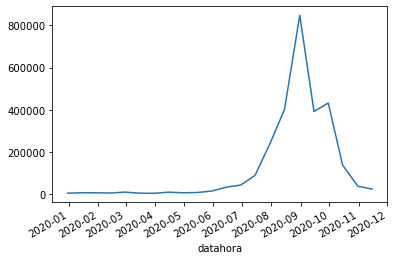

In [6]:
df_2020_biweekly.plot()

And by the plot above we obser the trend already discussed extensively
therein the other notebooks.

Okay, so these commands do what we need to be done to simplify the data. Now let's
implementing it for several years and write a new csv file containing only these information
to make some statistical analysis and afterwards the forecasting.

In [57]:
names = ['data2014', 'data2015', 'data2016', 'data2017', 'data2018', 'data2019', 'data2020']

for name in names:
    df = pd.read_csv('../../{}.csv'.format(name), index_col = 'datahora', parse_dates = True)
    df = df[df.riscofogo == 1]
    df_biweekly = df.resample('SM')['riscofogo'].sum().sort_index()
    df_biweekly.to_csv('../../{}_biweekly.csv'.format(name))

In [2]:
df2014 = pd.read_csv('../../data2014_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2015 = pd.read_csv('../../data2015_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2016 = pd.read_csv('../../data2016_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2017 = pd.read_csv('../../data2017_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2018 = pd.read_csv('../../data2018_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2019 = pd.read_csv('../../data2019_biweekly.csv', index_col = 'datahora', parse_dates = True)
df2020 = pd.read_csv('../../data2020_biweekly.csv', index_col = 'datahora', parse_dates = True)

df_all = pd.concat([df2014, df2015, df2016, df2017, df2018, df2019, df2020]).sort_index()

## Since there are duplicated indexes we need to sum them up

df_all = df_all.groupby(df_all.index).sum()

## Handling future *frequency warnings*

df_all = df_all.asfreq('SM')

df_all.index

DatetimeIndex(['2013-12-31', '2014-01-15', '2014-01-31', '2014-02-15',
               '2014-02-28', '2014-03-15', '2014-03-31', '2014-04-15',
               '2014-04-30', '2014-05-15',
               ...
               '2020-06-30', '2020-07-15', '2020-07-31', '2020-08-15',
               '2020-08-31', '2020-09-15', '2020-09-30', '2020-10-15',
               '2020-10-31', '2020-11-15'],
              dtype='datetime64[ns]', name='datahora', length=166, freq='SM-15')

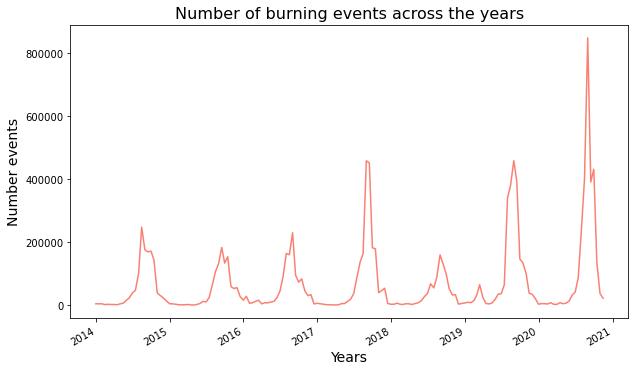

In [8]:
fig, ax = plt.subplots(figsize = (10,6))

ax.set_ylabel('Number events', fontsize = 14)
ax.set_xlabel('Years', fontsize = 14)
ax.set_title('Number of burning events across the years', fontsize = 16)
plt.gcf().autofmt_xdate()

ax.plot(df_all.riscofogo, color = 'salmon')

plt.show()

## Discussing the results

It is worthwhile highlighting that we have an increasing of the burning events from
2016 to 2017, but this number to less than half in 2018 (when compared to the latter).
However, in 2019, we a huge increment in 2019 when compared to 2018. Although
the biggest peak is roughly the same as in 2017, it has a non-negligiable
number of events at the beginning of the year (which is very unexpected,
since we know the humidity during this season is very high throughout
most of the country). Another point which really caughts our eyes is the enourmous
increament in 2020.

One would need to confirm that there is not images from different satelites
from the same part, however, if the number/frequency of image acquisition
hasn't change throughout the past years. If it hasn't this analysis is most
likely correct.

## Statistical analysis

As we have pointed out, we have a seasonal behavior throughout the years and
we also observe that there is a treand related to the increament throughout
the years. To make use of an ARIMA model rightway one would need to remove 
the seasonality (for example, by analyzing the differences between years
instead of the years themselves).

## Next steps

Within the next steps we are going to quantify better what we have described
above. Afterwards we are going to make use of the SARIMA model for making
the prediction for the next year. We start by making use of the
(A)ugmented (D)ickey-Fuller test, [adfuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test), which is a class from [statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html?highlight=adfuller#statsmodels.tsa.stattools.adfuller).
The null hypothesis is that it is a *non-stationary* process and the alternativa hypothesis
is that it is *stationary* process.

In [3]:
from statsmodels.tsa.stattools import adfuller

# H0: non-stationary
# H1: stationary

adfuller(df_all.riscofogo, autolag = None, maxlag = 23)

(-0.7284816511950395,
 0.8392335861669429,
 23,
 142,
 {'1%': -3.477261624048995,
  '5%': -2.8821181874544233,
  '10%': -2.5777431104939494})

where the first number is value associated to the ADF test made.
The second one is the p-test result and the last one are the critical
values to be compared to the first one. As we can check, we accept the
null hypothesis (our data is non-stationary). To make it is stationary
we have to get rid of the seasonal effects. That can be done by performing
a differencing. We then create a new column for our dataframe. Furthermore,
we also need to check whether there are a trend or not associated to this data.

In [5]:
## Since we have 12 months and we are taking a biweekly data (every two weeks)

df_all['seasonal_diff'] = df_all.riscofogo - df_all.riscofogo.shift(24)

df_all.head()

,riscofogo,seasonal_diff
datahora,,
2013-12-31,4962.0,NaN
2014-01-15,4822.0,NaN
2014-01-31,4806.0,NaN
2014-02-15,2223.0,NaN
2014-02-28,3436.0,NaN


In [11]:
adfuller(df_all.seasonal_diff.dropna(), autolag = None, maxlag = 23)

(-3.680018441705748,
 0.004403154500668664,
 23,
 118,
 {'1%': -3.4870216863700767,
  '5%': -2.8863625166643136,
  '10%': -2.580009026141913})

Nice, getting rid of the seasonal effects we obtain a stationary data.
Also, we one also observes graphically, there is no trend associated to it.

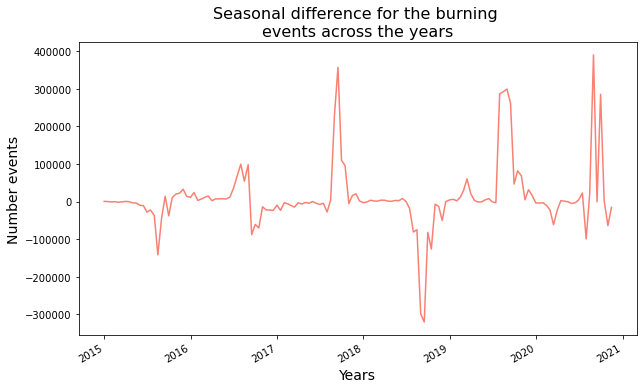

In [12]:
fig, ax = plt.subplots(figsize = (10,6))

ax.set_ylabel('Number events', fontsize = 14)
ax.set_xlabel('Years', fontsize = 14)
ax.set_title('Seasonal difference for the burning \nevents across the years', fontsize = 16)
plt.gcf().autofmt_xdate()

ax.plot(df_all.seasonal_diff, color = 'salmon')

plt.show()

## Investigation about the number of past events needed

Now that it is set to an stationary form, we need to investigate the number
of past events needed for the prediction of an event at a given moment $t$.
That is done by investigating the auto correlation function, that is, how the
function itself is correlated to its previous values in time. That allows us
to know the number of events needed for the prediction. To do so, we use the 
*plot_acf* (plot autocorrelation function) and the *plot_pacf* (p for partial) classes.

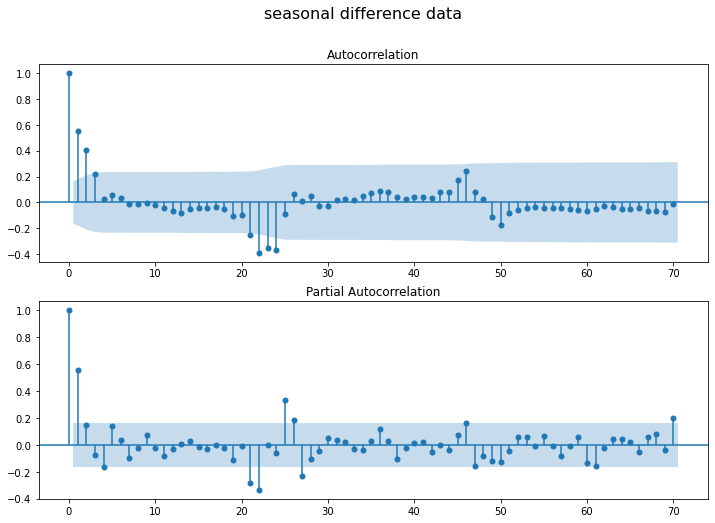

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## For the *seasonal_diff* data

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 8))

plot_acf(df_all.seasonal_diff.dropna(),lags=70,ax=ax1)
plot_pacf(df_all.seasonal_diff.dropna(),lags=70,ax=ax2)

fig.suptitle('seasonal difference data', fontsize=16)
plt.show()

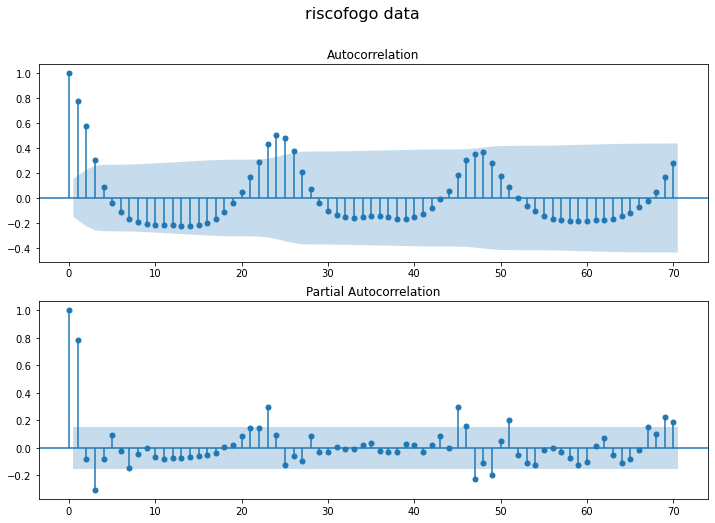

In [10]:
## For the *riscofogo* data

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 8))

plot_acf(df_all.riscofogo.dropna(),lags=70,ax=ax1)
plot_pacf(df_all.riscofogo.dropna(),lags=70,ax=ax2)

fig.suptitle('riscofogo data', fontsize=16)

plt.show()

The ARIMA model is defined by three quantities p, d, q.

> p corresponds to the information of the PACF

> d corresponds to the differencing process

> q corresponds to the ACF result

The ACF and PACF plots help us to have a better understanding of the relevant information
of our problem. Therein the ACF plot we observe a decaying pattern along the time, that is
a hint that we are dealing with an auto regressive process, *i.e.,* we can make inferences
based on previous data. We observe that there is a seasonal effect where the statistical significant
information is the previous year to the one analyzed (24 lags (semi month)). 

The PCFA helps us to understand the relevant lags to be included and it is apparently $p = (1, 3)$.
The q values are probably $q = (1, 2, 3)$. There is also the seasonal effect which have
to be take into account.

P.S.: It is also important to keep in mind that since our autocorrelation is of order 3, we can
predict at most three months in advance.

In [4]:
y_train = df_all[:len(df_all)-22]
y_test = df_all[len(df_all)-22:]

<AxesSubplot:xlabel='datahora'>

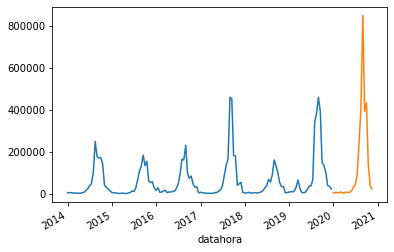

In [5]:
y_train.riscofogo.plot()
y_test.riscofogo.plot()

<AxesSubplot:xlabel='datahora'>

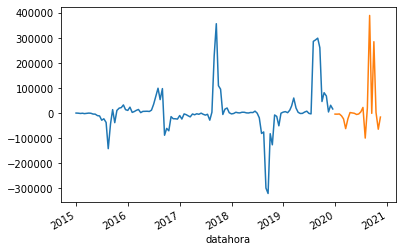

In [40]:
y_train.seasonal_diff.plot()
y_test.seasonal_diff.plot()

## Understanding the ACF and the PACF

From the ACF and PACF plots we observe that the functions are correlated
with the 3-4 data previously to that. And we also observer regular peaks 
each 24 data (as expected), these are related to the seasonality of our data.

Let's now create th possible values for our model.

In [6]:
p = range(0,3)
d = range(0,1)
q = range(0,4)

pdq = list(itertools.product(p, d, q))                                 ## pdq values
pdqs = [(p, d, q, 24) for p, d, q in itertools.product(p, d, q)]       ## pdq values for the seasonal part

pdqs

[(0, 0, 0, 24),
 (0, 0, 1, 24),
 (0, 0, 2, 24),
 (0, 0, 3, 24),
 (1, 0, 0, 24),
 (1, 0, 1, 24),
 (1, 0, 2, 24),
 (1, 0, 3, 24),
 (2, 0, 0, 24),
 (2, 0, 1, 24),
 (2, 0, 2, 24),
 (2, 0, 3, 24)]

Now lets start the investigation itself of the parameters by analyzing the
[AIC value](https://en.wikipedia.org/wiki/Akaike_information_criterion) for each model.
We are going to create a dicitionary containing the model parametes and the corresponding
AIC value of it. Afterwards we can choose the best model.

We start by analyzing the model for *riscofogo* column (since we are going to implement
SARIMA instead of ARIMA and afterwards we are going to implement it for the *seasonal_diff*
column.

In [29]:
aic_model_dict = dict()

for param in pdq:
    for seasonal_param in pdqs:

        sarimax = sm.tsa.statespace.SARIMAX(y_train.riscofogo, order = param,
                                            seasonal_order = seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        model_aic = sarimax.fit()
            
        print ('Model : {} x {}; AIC : {}'.format(param, seasonal_param, model_aic.aic))
        aic_model_dict[(param, seasonal_param)] = model_aic.aic

Model : (0, 0, 0) x (0, 0, 0, 24); AIC : 3730.798165778464
Model : (0, 0, 0) x (0, 0, 1, 24); AIC : 3102.5119314337217


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Model : (0, 0, 0) x (0, 0, 2, 24); AIC : 2421.3395948324114
Model : (0, 0, 0) x (0, 0, 3, 24); AIC : 1820.2208882600673
Model : (0, 0, 0) x (1, 0, 0, 24); AIC : 3062.6436776317832
Model : (0, 0, 0) x (1, 0, 1, 24); AIC : 2992.7452247532233
Model : (0, 0, 0) x (1, 0, 2, 24); AIC : 2391.390503239143
Model : (0, 0, 0) x (1, 0, 3, 24); AIC : 1787.046432833234
Model : (0, 0, 0) x (2, 0, 0, 24); AIC : 2394.8573241156423
Model : (0, 0, 0) x (2, 0, 1, 24); AIC : 2381.5923422238293
Model : (0, 0, 0) x (2, 0, 2, 24); AIC : 2387.8774410623637
Model : (0, 0, 0) x (2, 0, 3, 24); AIC : 1789.0328733819888
Model : (0, 0, 1) x (0, 0, 0, 24); AIC : 3604.5553785722313
Model : (0, 0, 1) x (0, 0, 1, 24); AIC : 2993.072042218579
Model : (0, 0, 1) x (0, 0, 2, 24); AIC : 2377.1085003080952
Model : (0, 0, 1) x (0, 0, 3, 24); AIC : 1775.0430470711544
Model : (0, 0, 1) x (1, 0, 0, 24); AIC : 3031.7190099743802
Model : (0, 0, 1) x (1, 0, 1, 24); AIC : 2966.253269732816
Model : (0, 0, 1) x (1, 0, 2, 24); AIC : 236

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 0, 3) x (1, 0, 3, 24); AIC : 1717.872734722708
Model : (0, 0, 3) x (2, 0, 0, 24); AIC : 2420.4327224792096
Model : (0, 0, 3) x (2, 0, 1, 24); AIC : 2420.9580047312716
Model : (0, 0, 3) x (2, 0, 2, 24); AIC : 2321.3238119129


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 0, 3) x (2, 0, 3, 24); AIC : 1719.3579854402903
Model : (1, 0, 0) x (0, 0, 0, 24); AIC : 3529.484176746413
Model : (1, 0, 0) x (0, 0, 1, 24); AIC : 2942.8579302097824
Model : (1, 0, 0) x (0, 0, 2, 24); AIC : 2345.3640902597044
Model : (1, 0, 0) x (0, 0, 3, 24); AIC : 1766.5036934667987
Model : (1, 0, 0) x (1, 0, 0, 24); AIC : 2934.5434034874784
Model : (1, 0, 0) x (1, 0, 1, 24); AIC : 2910.146272718424
Model : (1, 0, 0) x (1, 0, 2, 24); AIC : 2336.0841557297613
Model : (1, 0, 0) x (1, 0, 3, 24); AIC : 1754.315934371849
Model : (1, 0, 0) x (2, 0, 0, 24); AIC : 2337.700972000446
Model : (1, 0, 0) x (2, 0, 1, 24); AIC : 2334.7309614425444
Model : (1, 0, 0) x (2, 0, 2, 24); AIC : 2336.7266669436713
Model : (1, 0, 0) x (2, 0, 3, 24); AIC : 1756.3107478967895
Model : (1, 0, 1) x (0, 0, 0, 24); AIC : 3502.809005811997
Model : (1, 0, 1) x (0, 0, 1, 24); AIC : 2917.9553785925386
Model : (1, 0, 1) x (0, 0, 2, 24); AIC : 2322.39211224707
Model : (1, 0, 1) x (0, 0, 3, 24); AIC : 1741.4

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 0, 3) x (2, 0, 3, 24); AIC : 1682.799663467757
Model : (2, 0, 0) x (0, 0, 0, 24); AIC : 3502.1602636356056
Model : (2, 0, 0) x (0, 0, 1, 24); AIC : 2941.155701310634
Model : (2, 0, 0) x (0, 0, 2, 24); AIC : 2346.0281798952124
Model : (2, 0, 0) x (0, 0, 3, 24); AIC : 1765.8921735198116
Model : (2, 0, 0) x (1, 0, 0, 24); AIC : 2910.738169230059
Model : (2, 0, 0) x (1, 0, 1, 24); AIC : 2887.344433356846
Model : (2, 0, 0) x (1, 0, 2, 24); AIC : 2337.197151346016
Model : (2, 0, 0) x (1, 0, 3, 24); AIC : 1751.3367190245435
Model : (2, 0, 0) x (2, 0, 0, 24); AIC : 2314.4884228799624
Model : (2, 0, 0) x (2, 0, 1, 24); AIC : 2311.788179524897
Model : (2, 0, 0) x (2, 0, 2, 24); AIC : 2313.7793454597695
Model : (2, 0, 0) x (2, 0, 3, 24); AIC : 1753.2884696224385
Model : (2, 0, 1) x (0, 0, 0, 24); AIC : 3502.843172782954
Model : (2, 0, 1) x (0, 0, 1, 24); AIC : 2918.47675139636
Model : (2, 0, 1) x (0, 0, 2, 24); AIC : 2324.297998244868
Model : (2, 0, 1) x (0, 0, 3, 24); AIC : 1739.9178

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 2) x (1, 0, 3, 24); AIC : 1704.9504687083008
Model : (2, 0, 2) x (2, 0, 0, 24); AIC : 2317.9266225356864
Model : (2, 0, 2) x (2, 0, 1, 24); AIC : 2313.469810253654
Model : (2, 0, 2) x (2, 0, 2, 24); AIC : 2291.4380122693137


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 2) x (2, 0, 3, 24); AIC : 1706.892569510835
Model : (2, 0, 3) x (0, 0, 0, 24); AIC : 3452.2571203406123
Model : (2, 0, 3) x (0, 0, 1, 24); AIC : 2866.2714388278464
Model : (2, 0, 3) x (0, 0, 2, 24); AIC : 2279.4641618660658
Model : (2, 0, 3) x (0, 0, 3, 24); AIC : 1695.562426476028
Model : (2, 0, 3) x (1, 0, 0, 24); AIC : 2908.851659382344
Model : (2, 0, 3) x (1, 0, 1, 24); AIC : 2843.4553964476468
Model : (2, 0, 3) x (1, 0, 2, 24); AIC : 2268.276745517251


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 3) x (1, 0, 3, 24); AIC : 1681.0774380282862
Model : (2, 0, 3) x (2, 0, 0, 24); AIC : 2319.401441319999
Model : (2, 0, 3) x (2, 0, 1, 24); AIC : 2314.764659768476
Model : (2, 0, 3) x (2, 0, 2, 24); AIC : 2269.1055699379253


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 3) x (2, 0, 3, 24); AIC : 1682.2369545440504


In [36]:
for key in aic_model_dict:
    if aic_model_dict[key] < 1690:
        print (key, aic_model_dict[key])

((1, 0, 3), (1, 0, 3, 24)) 1680.8845180263957
((1, 0, 3), (2, 0, 3, 24)) 1682.799663467757
((2, 0, 3), (1, 0, 3, 24)) 1681.0774380282862
((2, 0, 3), (2, 0, 3, 24)) 1682.2369545440504


## Convergence issues for the best models using the riscofogo model

the best models using riscofogo were having some issues regarding
the convergence of the likelihood optimization. Let's try to increase
order of $p$ and $q$ in one unity.

In [41]:
aic_model_dict_diff = dict()

for param in pdq:
    for seasonal_param in pdqs:

        sarimax_diff = sm.tsa.statespace.SARIMAX(y_train.seasonal_diff, order = param,
                                            seasonal_order = seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        model_aic_diff = sarimax_diff.fit()
            
        print ('Model : {} x {}; AIC : {}'.format(param, seasonal_param, model_aic_diff.aic))
        aic_model_dict_diff[(param, seasonal_param)] = model_aic_diff.aic

Model : (0, 0, 0) x (0, 0, 0, 24); AIC : 3066.849641911106
Model : (0, 0, 0) x (0, 0, 1, 24); AIC : 3033.156592877414


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Model : (0, 0, 0) x (0, 0, 2, 24); AIC : 2386.4748978337448
Model : (0, 0, 0) x (0, 0, 3, 24); AIC : 1789.12789478757
Model : (0, 0, 0) x (1, 0, 0, 24); AIC : 2985.7642891594433
Model : (0, 0, 0) x (1, 0, 1, 24); AIC : 2957.0502699292256
Model : (0, 0, 0) x (1, 0, 2, 24); AIC : 2382.96857094863
Model : (0, 0, 0) x (1, 0, 3, 24); AIC : 1790.2793408700336
Model : (0, 0, 0) x (2, 0, 0, 24); AIC : 2386.7994563084812
Model : (0, 0, 0) x (2, 0, 1, 24); AIC : 2376.6474289805346
Model : (0, 0, 0) x (2, 0, 2, 24); AIC : 2379.5013941205552
Model : (0, 0, 0) x (2, 0, 3, 24); AIC : 1787.3891369131766
Model : (0, 0, 1) x (0, 0, 0, 24); AIC : 3006.6516530722265
Model : (0, 0, 1) x (0, 0, 1, 24); AIC : 2932.370644171816
Model : (0, 0, 1) x (0, 0, 2, 24); AIC : 2334.311510200743
Model : (0, 0, 1) x (0, 0, 3, 24); AIC : 1739.8229224366303
Model : (0, 0, 1) x (1, 0, 0, 24); AIC : 2974.454516175067
Model : (0, 0, 1) x (1, 0, 1, 24); AIC : 2927.0895059411164
Model : (0, 0, 1) x (1, 0, 2, 24); AIC : 2333.5

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 0, 3) x (2, 0, 3, 24); AIC : 1689.2731702935405
Model : (2, 0, 0) x (0, 0, 0, 24); AIC : 2983.759035515285
Model : (2, 0, 0) x (0, 0, 1, 24); AIC : 2931.04080960555
Model : (2, 0, 0) x (0, 0, 2, 24); AIC : 2343.545012334934
Model : (2, 0, 0) x (0, 0, 3, 24); AIC : 1758.8906040881657
Model : (2, 0, 0) x (1, 0, 0, 24); AIC : 2901.806585565672
Model : (2, 0, 0) x (1, 0, 1, 24); AIC : 2903.612153107743
Model : (2, 0, 0) x (1, 0, 2, 24); AIC : 2342.8089916820395
Model : (2, 0, 0) x (1, 0, 3, 24); AIC : 1759.1141505636588
Model : (2, 0, 0) x (2, 0, 0, 24); AIC : 2317.499249749355
Model : (2, 0, 0) x (2, 0, 1, 24); AIC : 2318.0406080180937
Model : (2, 0, 0) x (2, 0, 2, 24); AIC : 2320.7470557609668
Model : (2, 0, 0) x (2, 0, 3, 24); AIC : 1760.5179292988719
Model : (2, 0, 1) x (0, 0, 0, 24); AIC : 2985.44464262681
Model : (2, 0, 1) x (0, 0, 1, 24); AIC : 2908.1290130284715
Model : (2, 0, 1) x (0, 0, 2, 24); AIC : 2320.4273289208254
Model : (2, 0, 1) x (0, 0, 3, 24); AIC : 1731.442

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 1) x (2, 0, 2, 24); AIC : 16.0


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 1) x (2, 0, 3, 24); AIC : 589.2609600656344
Model : (2, 0, 2) x (0, 0, 0, 24); AIC : 2985.9457495536617
Model : (2, 0, 2) x (0, 0, 1, 24); AIC : 2886.9860734805993
Model : (2, 0, 2) x (0, 0, 2, 24); AIC : 2298.970117643165


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 2) x (0, 0, 3, 24); AIC : 16.0
Model : (2, 0, 2) x (1, 0, 0, 24); AIC : 2906.517302679153
Model : (2, 0, 2) x (1, 0, 1, 24); AIC : 2883.853791283623
Model : (2, 0, 2) x (1, 0, 2, 24); AIC : 2299.0826241379414
Model : (2, 0, 2) x (1, 0, 3, 24); AIC : 18.0
Model : (2, 0, 2) x (2, 0, 0, 24); AIC : 2321.130834092402
Model : (2, 0, 2) x (2, 0, 1, 24); AIC : 2321.382880919083
Model : (2, 0, 2) x (2, 0, 2, 24); AIC : 2301.0488014707776


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 2) x (2, 0, 3, 24); AIC : 1713.2956600577256
Model : (2, 0, 3) x (0, 0, 0, 24); AIC : 2985.0366900606386
Model : (2, 0, 3) x (0, 0, 1, 24); AIC : 2864.19455825353
Model : (2, 0, 3) x (0, 0, 2, 24); AIC : 2277.00615385969
Model : (2, 0, 3) x (0, 0, 3, 24); AIC : 1687.4843382841327
Model : (2, 0, 3) x (1, 0, 0, 24); AIC : 2908.531373986933
Model : (2, 0, 3) x (1, 0, 1, 24); AIC : 2861.60600699981
Model : (2, 0, 3) x (1, 0, 2, 24); AIC : 2277.226654853673


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 3) x (1, 0, 3, 24); AIC : 1688.2350998710788
Model : (2, 0, 3) x (2, 0, 0, 24); AIC : 2323.2085370374166
Model : (2, 0, 3) x (2, 0, 1, 24); AIC : 2323.3920787858524
Model : (2, 0, 3) x (2, 0, 2, 24); AIC : 2279.1941967459206


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 0, 3) x (2, 0, 3, 24); AIC : 1688.225702459406


In [42]:
for key in aic_model_dict_diff:
    if aic_model_dict_diff[key] < 1000:
        print (key, aic_model_dict_diff[key])

((2, 0, 1), (1, 0, 1, 24)) 12.0
((2, 0, 1), (2, 0, 0, 24)) 12.0
((2, 0, 1), (2, 0, 1, 24)) 14.0
((2, 0, 1), (2, 0, 2, 24)) 16.0
((2, 0, 1), (2, 0, 3, 24)) 589.2609600656344
((2, 0, 2), (0, 0, 3, 24)) 16.0
((2, 0, 2), (1, 0, 3, 24)) 18.0


In [8]:
### MODELS ACQUIRED BY TESTING THE AIC

#((1, 0, 3), (1, 0, 3, 24)) 1680.8845180263957
#((1, 0, 3), (2, 0, 3, 24)) 1682.799663467757
#((2, 0, 3), (1, 0, 3, 24)) 1681.0774380282862
#((2, 0, 3), (2, 0, 3, 24)) 1682.2369545440504


### MODEL ACQUIRED ANALYZING ACF AND PACF
# (3, 0, 3), (2, 0, 1, 24) ## seasonal p = 2 or 3


my_order = (2, 0, 3)
my_sorder = (2, 0, 1, 24) 

model_riscofogo = sm.tsa.statespace.SARIMAX(y_train.riscofogo,
                                            order = my_order,
                                            seasonal_order = my_sorder,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

model_riscofogo_fit = model_riscofogo.fit()

In [127]:
print(model_riscofogo_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            riscofogo   No. Observations:                  144
Model:             SARIMAX(2, 0, 3)x(2, 0, [1], 24)   Log Likelihood               -1148.382
Date:                              Tue, 08 Dec 2020   AIC                           2314.765
Time:                                      14:56:03   BIC                           2337.654
Sample:                                  12-31-2013   HQIC                          2324.010
                                       - 12-15-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3516      1.932      0.182      0.856      -3.434       4.137
ar.L2          0.07

In [11]:
predictions = model_riscofogo_fit.forecast(len(y_test))

residuals = y_test.riscofogo - predictions

residuals.tail(10)

datahora
2020-06-30    -10881.841775
2020-07-15    -14656.565950
2020-07-31     87426.812451
2020-08-15    199103.331194
2020-08-31    479749.355408
2020-09-15     69468.516586
2020-09-30    250914.881593
2020-10-15    -15350.065476
2020-10-31    -23692.406438
2020-11-15    -32438.062056
Freq: SM-15, dtype: float64

In [129]:
MAE = np.mean(abs(residuals/y_test.riscofogo))

print ('Mean absolute error in percentage : {}'.format(round(100*MAE, 2)))

Mean absolute error in percentage : 62.43


 we see that the error is quite high, let's analyze it graphically to help us
understand why the model is doing so

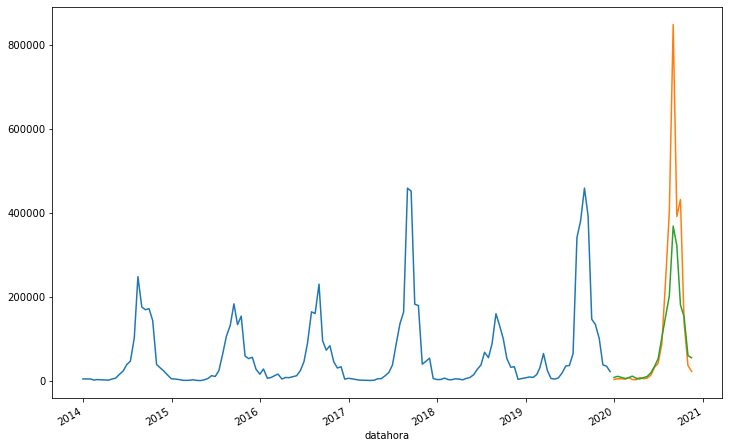

In [130]:
fig, ax = plt.subplots(figsize = (12, 8))

y_train.riscofogo.plot()
y_test.riscofogo.plot()
predictions.plot()

plt.show()

Okay, so it is easy to understand why: the years 2014, 2015, 2016
have roughly the same amplitudes. In 2017 there is this bigger peak
(compared to previous years), than one has a  small peak in 2018 
and a bigger one in 2019 (comparable to the 2017 one). The model
predicted that compared to the previous ones this year we were
going to have a slightly smaller peak compared to 2019. But this was
not the cause though. We had a huge increament. There is the chance
of the satellite data have being acquired more frequently and therefore
(by the analysis that we have performed) it led us to obtain a bigger
number of burning events. To investigate this we would need to count
the frequency of data registration along the years and normalize it
(perhaps do a daily normnalization on the data, that would fix that
in the sense of: we have much more data due tho the fact that it was
acquired much more frequently, but we are also dividing by this big number).

However, there is a different approach that we can make before doing
this, which would allow us to refine our model (which might also be helpful
within the near future). We can make use of a technique called *Rolling Forecast Origin* (RFO).
The RFO technique consists in instead of predicting what is going to happen
in the entire year, one makes a prediction for the next few months based
on what we know until now, then for the sequent month we update the model
and and carry on this analysis. It is a kind of a self correction for
for long time period models. The main issue here is related to the
order of our moving average model (consequently, the order of the
correlation function). Since our model is of order three, we can only
confidently predict one to one month and half in advance. Afterwards
the model stabilizes at its mean value (please note the value of the highest peak)
of our prediction). The next section is devoted to implementing it.

In [48]:
# monthly prediction

rfo_predictions = pd.Series()


for data_end in y_test.index:
    y_data_for = df_all[: data_end - relativedelta(months = 1)]
    model = sm.tsa.statespace.SARIMAX(y_data_for, order = my_order,
                                      seasonal_order = my_sorder,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.fit()
    pred = model_fit.predict(data_end)
    rfo_predictions.loc[data_end] = pred.loc[data_end]

<ipython-input-48-ab17981405cd>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  rfo_predictions = pd.Series()


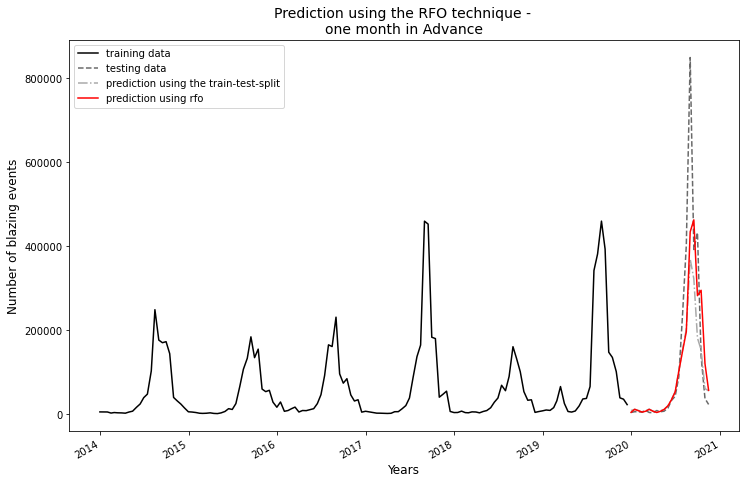

In [89]:
fig, ax = plt.subplots(figsize = (12, 8))



ax.plot(y_train.riscofogo, label = 'training data', color = 'k')
ax.plot(y_test.riscofogo, label = 'testing data', color = 'dimgrey', linestyle = '--')
ax.plot(predictions, label = 'prediction using the train-test-split', color = 'darkgray', linestyle = '-.')
ax.plot(rfo_predictions, label = 'prediction using rfo', color = 'red')

ax.set_ylabel('Number of blazing events', fontsize = 12)
ax.set_xlabel('Years', fontsize = 12)

plt.gcf().autofmt_xdate()

plt.title('Prediction using the RFO technique - \none month in Advance', fontsize = 14)

plt.legend()

plt.show()



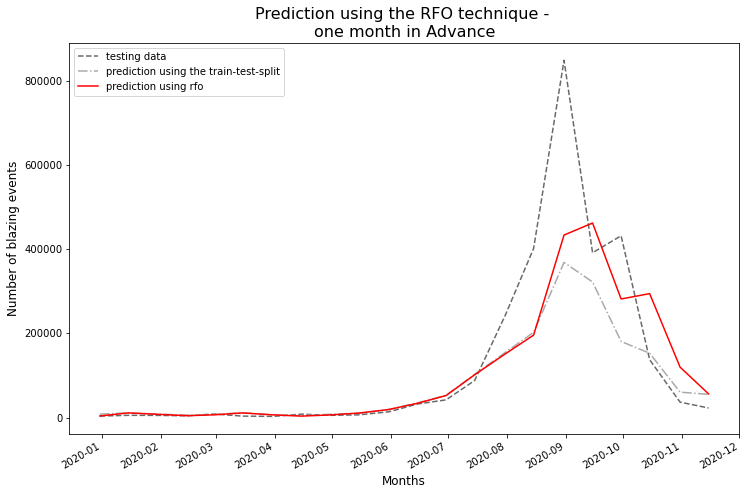

In [90]:
fig, ax = plt.subplots(figsize = (12, 8))


ax.plot(y_test.riscofogo, label = 'testing data', color = 'dimgrey', linestyle = '--')
ax.plot(predictions, label = 'prediction using the train-test-split', color = 'darkgray', linestyle = '-.')
ax.plot(rfo_predictions, label = 'prediction using rfo', color = 'red')

ax.set_xlabel('Months', fontsize = 12)
ax.set_ylabel('Number of blazing events', fontsize = 12)

plt.gcf().autofmt_xdate()

plt.title('Prediction using the RFO technique - \none month in Advance', fontsize = 16)

plt.legend()

plt.show()

In [51]:
# biweekly prediction

rfo_predictions_bw = pd.Series()


for data_end in y_test.index:
    y_data_for = df_all[: data_end - timedelta(days = 1)]
    model = sm.tsa.statespace.SARIMAX(y_data_for, order = my_order,
                                      seasonal_order = my_sorder,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.fit()
    pred = model_fit.predict(data_end)
    rfo_predictions_bw.loc[data_end] = pred.loc[data_end]

<ipython-input-51-6e5fe23a9abb>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  rfo_predictions_bw = pd.Series()


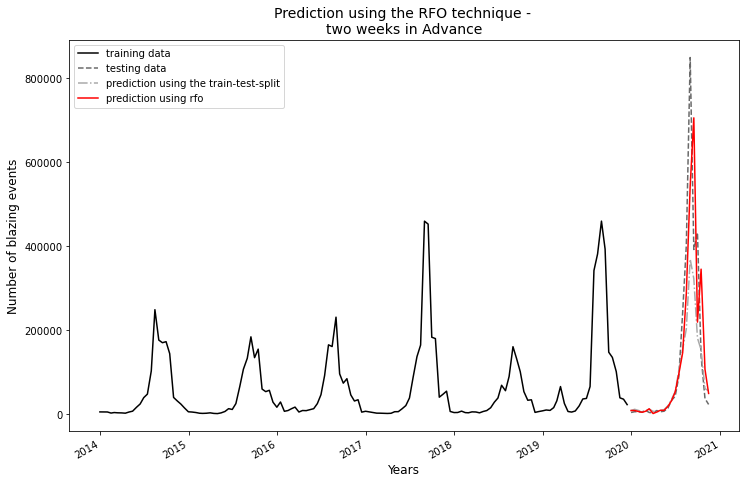

In [91]:
fig, ax = plt.subplots(figsize = (12, 8))



ax.plot(y_train.riscofogo, label = 'training data', color = 'k')
ax.plot(y_test.riscofogo, label = 'testing data', color = 'dimgrey', linestyle = '--')
ax.plot(predictions, label = 'prediction using the train-test-split', color = 'darkgray', linestyle = '-.')
ax.plot(rfo_predictions_bw, label = 'prediction using rfo', color = 'red')

ax.set_ylabel('Number of blazing events', fontsize = 12)
ax.set_xlabel('Years', fontsize = 12)

plt.gcf().autofmt_xdate()

plt.title('Prediction using the RFO technique - \ntwo weeks in Advance', fontsize = 14)

plt.legend()

plt.show()

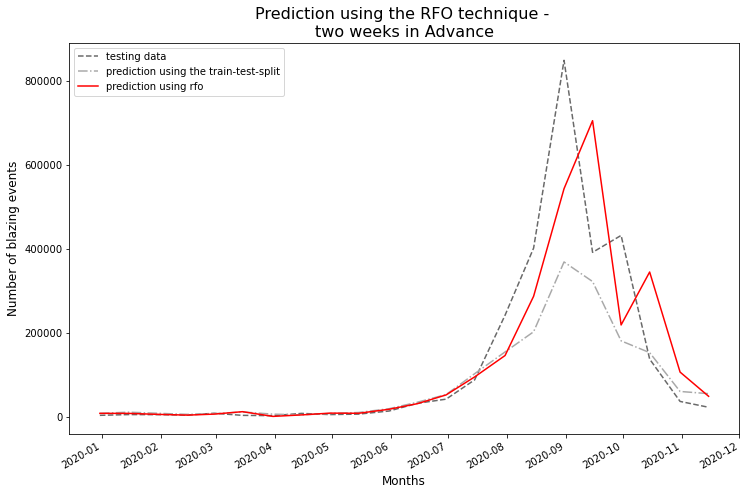

In [92]:
fig, ax = plt.subplots(figsize = (12, 8))


ax.plot(y_test.riscofogo, label = 'testing data', color = 'dimgrey', linestyle = '--')
ax.plot(predictions, label = 'prediction using the train-test-split', color = 'darkgray', linestyle = '-.')
ax.plot(rfo_predictions_bw, label = 'prediction using rfo', color = 'red')

ax.set_xlabel('Months', fontsize = 12)
ax.set_ylabel('Number of blazing events', fontsize = 12)

plt.gcf().autofmt_xdate()

plt.title('Prediction using the RFO technique - \ntwo weeks in Advance', fontsize = 16)

plt.legend()

plt.show()